In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
import tensorflow.keras as keras
import tensorflow as tf
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.layers.convolutional import MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout

In [2]:
# 얼리스탑핑 쉽게
def model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, patience):
    save_file_name = model_name
    cb_checkpoint,cb_earlystopping = checkpoint_ez(MODEL_SAVE_FOLDER_PATH, save_file_name, patience)
    return cb_checkpoint,cb_earlystopping

def checkpoint_ez(MODEL_SAVE_FOLDER_PATH,save_file_name, patience) : 
    MODEL_SAVE_FOLDER_PATH = MODEL_SAVE_FOLDER_PATH
    data_name = save_file_name
    model_path = MODEL_SAVE_FOLDER_PATH + data_name + '.hdf5'
    # val_loss 값이 낮아졌을(좋아졌을) 때만 저장
    cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',
                                    verbose=1, save_best_only=True
                                   )
    cb_earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience = patience, verbose=1,
                                                  mode='auto', baseline=None, restore_best_weights=False)
    return cb_checkpoint, cb_earlystopping

# 그래프 쉽게
def loss_graph(label1,label2,bottom,top):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label=label1)
    loss_ax.plot(history.history['val_loss'], 'r', label=label2)
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    # acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')
    loss_ax.set_ylim(bottom,top)
    return plt.show()

# 모델 저장 def
def json_model_saver(MODEL_SAVE_FOLDER_PATH,file_name):
    # model save by json
    # load model 
    model = keras.models.load_model(MODEL_SAVE_FOLDER_PATH +file_name+ '.hdf5')
    # Save model with json format
    model_json = model.to_json()
    with open(MODEL_SAVE_FOLDER_PATH+file_name+'.json', "w") as json_file:
        json_file.write(model_json)
    # Save weight with h5 format
    model.save_weights( MODEL_SAVE_FOLDER_PATH +file_name +'.h5')
    return print("Saved model to disk : "+ file_name +'.h5')


In [3]:
# 데이터 불러오기
path_AL = '../9.data/0.work_data/3.Accident_list/'

AccList_accident = pd.read_csv(path_AL + 'AccList_accident.csv', header=None, index_col=0)
AccList_pattern = pd.read_csv(path_AL + 'AccList_pattern.csv', header=None, index_col=0)

In [4]:
AccList_accident = AccList_accident.reset_index()
AccList_accident = AccList_accident.reset_index(0, drop = False)
AccList_accident = AccList_accident.set_index(0, drop = True)

AccList_pattern = AccList_pattern.reset_index()
AccList_pattern = AccList_pattern.reset_index(0, drop = True)

In [5]:
# Accident, Nonaccident 리스트 불러오기
diff_path = '../9.data/1.accData_split/1.diff_heatmap/'
acclist = os.listdir(diff_path + 'accident/')
nonacclist = os.listdir(diff_path + 'nonaccident/')

for i in range(len(acclist)):
    acclist[i] = acclist[i].split('.')[0]
accData = AccList_accident.loc[acclist]
pattData = AccList_pattern.loc[accData.set_index('index').index]

for i in range(len(nonacclist)):
    nonacclist[i] = nonacclist[i].split('.')[0]
nonAccData = AccList_accident.loc[nonacclist]
nonPattData = AccList_pattern.loc[nonAccData.set_index('index').index]

In [6]:
del accData['index']
pattData = pattData.set_index(0, drop = True)

del nonAccData['index']
nonPattData = nonPattData.set_index(0, drop = True)

In [7]:
accData['y'] = 1
nonAccData['y'] = 0
data1 = pd.concat([accData, nonAccData])
data2 = pd.concat([pattData, nonPattData])

In [8]:
# 데이터 섞은 후 배열로 만들기

np.random.seed(0)
randomList = list(np.random.randint(2000, size = 2000))
data1 = data1.reset_index(drop=True)
data1 = data1.loc[randomList]
data1 = data1.reset_index(drop=True)
data2 = data2.reset_index(drop=True)
data2 = data2.loc[randomList]
data2 = data2.reset_index(drop=True)

In [9]:
print(data1.max().max())
print(data2.max().max())

143.0
108.16129032258064


In [10]:
# dataX = data1.T[:-1].T
# dataX = dataX/143
# data2 = data2/143
# dataX = np.expand_dims(dataX, 1)
# data2 = np.expand_dims(data2, 1)
# dataX = np.concatenate((dataX, data2), axis=1)

# dataY = data1['y']

dataX = data1.T[:-1].T
dataX = dataX/143
data2 = data2/143
dataX = np.expand_dims(dataX, -1)
data2 = np.expand_dims(data2, -1)
dataX = np.concatenate((dataX, data2), axis=2)

dataY = data1['y']

In [11]:
dataX = np.array(dataX)
dataY = dataY.array

# input data 생성
nTrain = 1500
nTest = 500

x_train = dataX[:nTrain, :561]
x_test = dataX[:nTest, :561]
y_train = dataY[:nTrain]
y_test = dataY[:nTest]

In [18]:
x_train.shape

(1500, 51, 11, 2)

In [12]:
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [13]:
# # 데이터 reshape
# x_train = x_train.reshape(x_train.shape[0],2,51,11)
# x_test = x_test.reshape(x_test.shape[0],2,51,11)

# 데이터 reshape
x_train = x_train.reshape(x_train.shape[0],51,11,2)
x_test = x_test.reshape(x_test.shape[0],51,11,2)

AxesImage(54,36;334.8x217.44)
0    0
1    1
Name: 100, dtype: uint8


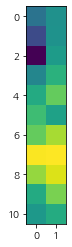

In [19]:
n = 100
print(plt.imshow(x_train[n][0][:][:]))
#print(plt.imshow(x_train[n][1][:][:]))
print(y_train[:].iloc[n])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 9, 8)          152       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 4, 8)          0         
_________________________________________________________________
flatten (Flatten)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7690      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 7,864
Trainable params: 7,864
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6970 - accuracy: 0.4771
Epoch 00001: val_loss 

Epoch 26/1000
105/120 [=========================>....] - ETA: 0s - loss: 0.6936 - accuracy: 0.5010
Epoch 00026: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6936 - accuracy: 0.5017 - val_loss: 0.6941 - val_accuracy: 0.4533
Epoch 27/1000
102/120 [========================>.....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4961
Epoch 00027: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4983 - val_loss: 0.6919 - val_accuracy: 0.5467
Epoch 28/1000
103/120 [========================>.....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4864
Epoch 00028: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4917 - val_loss: 0.6922 - val_accuracy: 0.5467
Epoch 29/1000
103/120 [========================>.....] - ETA: 0s - loss: 0.6935 - accuracy: 0.4854
Epoch 00029: val_loss did not improve from 0.69079
120/120

101/120 [========================>.....] - ETA: 0s - loss: 0.6937 - accuracy: 0.4802
Epoch 00055: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6937 - accuracy: 0.4783 - val_loss: 0.6928 - val_accuracy: 0.5467
Epoch 56/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5009
Epoch 00056: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6935 - accuracy: 0.4950 - val_loss: 0.6933 - val_accuracy: 0.4533
Epoch 57/1000
109/120 [==========================>...] - ETA: 0s - loss: 0.6941 - accuracy: 0.4927
Epoch 00057: val_loss did not improve from 0.69079
120/120 [==============================] - 0s 2ms/step - loss: 0.6939 - accuracy: 0.4950 - val_loss: 0.6928 - val_accuracy: 0.5467
Epoch 58/1000
110/120 [==========================>...] - ETA: 0s - loss: 0.6934 - accuracy: 0.4936
Epoch 00058: val_loss did not improve from 0.69079
120/120 [============

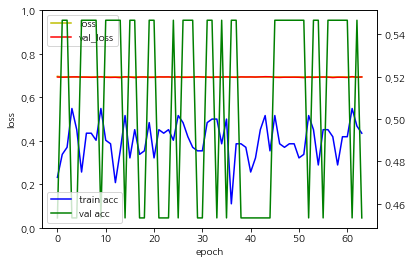

In [15]:
model_name = 'test'
MODEL_SAVE_FOLDER_PATH = '../1.model'
cb_checkpoint,cb_earlystopping = model_save_erstp(MODEL_SAVE_FOLDER_PATH, model_name, 50)

tf.keras.backend.clear_session()


model = Sequential()
model.add(layers.Conv2D(filters=8, kernel_size = 3 , input_shape=(51,11,2), activation='relu', kernel_initializer='he_normal')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=10, activation='relu', kernel_initializer='he_normal')) 
model.add(layers.Dense(units=2, activation='sigmoid'))
model.compile(loss ='binary_crossentropy', optimizer=optimizers.Adam(lr=0.01), metrics=['accuracy'])
model.summary()

history = model.fit(x_train, y_train, shuffle=True,epochs=1000, batch_size=10, validation_split=0.2, callbacks=[cb_checkpoint,cb_earlystopping])
loss_graph('loss','val_loss',0,1)

In [16]:
loss, acc = model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 3ms/step - loss: 0.6929 - accuracy: 0.5220


In [198]:
y_test

,0.0,1.0
0,0,1
1,0,1
2,1,0
3,1,0
4,0,1
...,...,...
495,1,0
496,1,0
497,0,1
498,1,0


In [207]:
import matplotlib.pyplot as plt

plt.imshow(test[10])

NameError: name 'test' is not defined

In [121]:
test[0].shape

(51, 11)

In [120]:
img.shape

(1670, 2400, 3)

In [78]:
accPath = '../9.data/1.accData_split/1.diff_heatmap/accident/'
nonaccPath = '../9.data/1.accData_split/1.diff_heatmap/nonaccident/'

acc_list = os.listdir(accPath)
nonacc_list = os.listdir(nonaccPath)

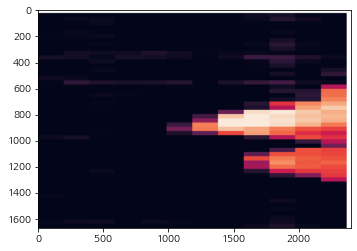

In [122]:
img = cv2.imread(accPath + acc_list[50])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [102]:
num = 0
for i in acc_list:    
    if num == 0:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        x_train = np.expand_dims(img, 0)
        num += 1
    else:
        img = cv2.imread(accPath + i)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.expand_dims(img, 0)
        x_train = np.concatenate((x_train, img), axis=0)


KeyboardInterrupt: 

TypeError: Invalid shape (1, 1670, 2400, 3) for image data

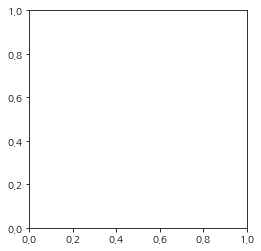

In [103]:
import matplotlib.pyplot as plt
plt.imshow(img)

In [113]:
img = cv2.imread(accPath + acc_list[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)